# Análisis del perfil turístico que visitó Gran Canaria 2022

# **1.Preparación de los datos**


**Imports**
Se importan las librerias, módulos y funciones que vamos a usar a lo largo del análisis.

In [1]:
#Librerias que vamos a usar a lo largo del EDA
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import stats, f_oneway, chi2_contingency
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import sys
sys.path.insert(0,"../utils")
import utils as funciones

# **1.2 Carga de la base de datos y limpieza**

In [2]:
#Llamamos al csv y creamos el df de perfil turistico
df_perfil_turistico = pd.read_csv("./data/Perfil_turístico.csv", sep=";", encoding="latin1")
#LIMPIEZA DE LOS DATOS
# Sexo
df_perfil_turistico["Sexo"] = df_perfil_turistico["Sexo"].replace({1: "Hombre", 6: "Mujer"})
#Nivel educativo
df_perfil_turistico["Nivel_educativo"] = df_perfil_turistico["Nivel_educativo"].replace({1:"Sin estudios", 2:"Estudios primarios", 3:"Estudios secundarios", 4:"Estudios superiores"})
#Situacion laboral
df_perfil_turistico["Situacion_laboral"] = df_perfil_turistico["Situacion_laboral"].replace({ 1:"Asalariado", 2:"Autonomo", 3:"Empresario_peque", 4:"Empresario_grande",
5:"Desempleado", 6:"Estudiante", 7:"Jubilado", 8:"Incapacitado", 9:"Militar", 10:"Dependients", 11:"Otros"})
#Ingresos
df_perfil_turistico["Ingresos"] = df_perfil_turistico["Ingresos"].replace({1:"Menos 25.000", 2:"25.000-49.999",3:"50.000-74.999", 4:"+75.000"})
#Tipo de alojamiento
df_perfil_turistico["Tipo_alojamiento"] = df_perfil_turistico["Tipo_alojamiento"].replace({1:"Hotel 1-2-3*", 2:"Hotel 4*",3:"Hotel 5*", 4:"Apartamento/Villa", 5:"Vivienda/airbnb", 6:"Alojamiento privado", 7:"Alojamiento rural"})
#Repetiría
df_perfil_turistico["Repetiria"] = df_perfil_turistico["Repetiria"].replace({1:"(1)", 2:"(2)",3:"(3)", 4:"(4)", 5:"(5)", 6:"(6)", 7:"(7)",8:"(8)",9:"(9)",10:"(10)"})
#Calificacion
df_perfil_turistico["Calificacion"] = df_perfil_turistico["Calificacion"].replace({1:"Mucho peor de lo esperado", 2:"Peor de lo esperado",3:"A la altura de las expectativas", 4:"Mejor de lo esperado", 5:"Mucho mejor de lo esperado"})
#Creamos una columna con el tipo de acompañante para tener en la misma columna el "modo_viaje" y asi estudiarla mejor
columnas_tipo_acompañante = ["Viaja_solo", "Viaja_pareja", "Viaja_hijo", "Viaja_amigos", "Viaja_otros"]
df_perfil_turistico["Modo_viaje"] = df_perfil_turistico.apply(lambda row: ', '.join(col for col in columnas_tipo_acompañante if row[col] == "Si"), axis=1)
df_perfil_turistico = df_perfil_turistico.drop(columns=["Viaja_pareja","Viaja_hijo","Viaja_otros","Viaja_solo","Viaja_amigos"])
# Convertir algunas columnas a float
df_perfil_turistico['Edad'] = df_perfil_turistico['Edad'].astype(float)
df_perfil_turistico['Noches'] = df_perfil_turistico['Noches'].astype(float)
df_perfil_turistico['Personas_hogar'] = df_perfil_turistico['Personas_hogar'].astype(float)
variables_numericas=["Edad","Noches","Coste_vuelos","Coste_alojamiento","Gastos","Horas_fuera_alojamiento","Visitas_totales_Islas","Visitas_total_GC","Personas_hogar"]
# Reemplazar valores fuera del rango por la mediana
for var in variables_numericas:
    q1 = df_perfil_turistico[var].quantile(0.25)
    q3 = df_perfil_turistico[var].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    median = df_perfil_turistico[var].median()
    df_perfil_turistico[var] = df_perfil_turistico[var].apply(lambda x: median if (x < lower_bound or x > upper_bound) else x)

#ESTUDIO DE LOS DATOS
#Datos prepandemia
df_2019 = df_perfil_turistico[df_perfil_turistico['Año'] == 2019]
#Datos postpandemia
df_2022 = df_perfil_turistico[df_perfil_turistico['Año'] == 2022]
#Conjunto 
df_2019_2022 = df_perfil_turistico[df_perfil_turistico['Año'].isin([2019, 2022])]
#Definimos grupos de variables
variables_categoricas=["Sexo","Nacionalidad","Tipo_alojamiento","Calificacion","Repetiria","Nivel_educativo","Situacion_laboral","Ingresos", "Modo_viaje"]

# **4. Análisis Multivariante**

Queremos evaluar cómo influyen múltiples variables

Veamos los patrones en los turistas postpandemia, usando el análisis de Componentes Principales (PCA) para reducir la dimensionalidad y encontrar patrones subyacentes
El Análisis de Componentes Principales (PCA) nos será útil ya que tenemos muchas variables y queremos identificar patrones subyacentes, visualizando los datos en menos dimensiones sin perder demasiada información. 
El PCA agrupa variables correlacionadas y permite identificar los componentes principales que explican la mayor parte de la varianza en los datos.

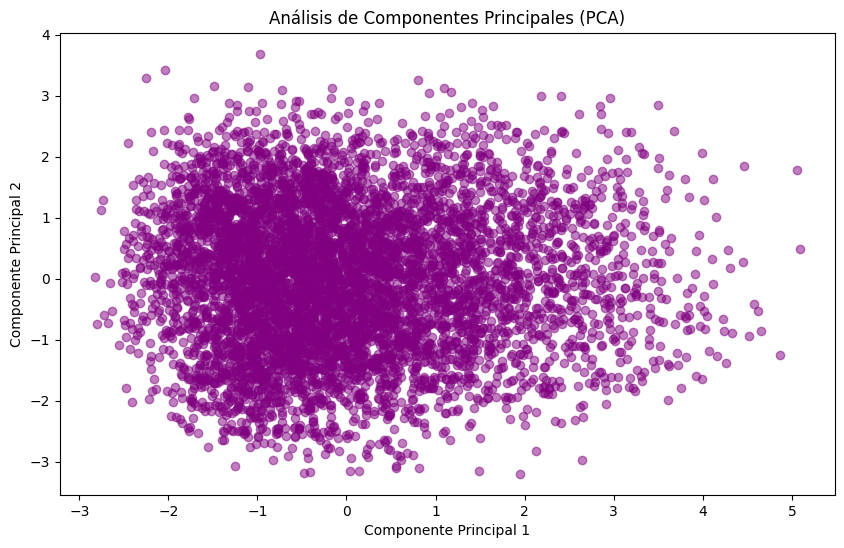

Varianza explicada por los componentes principales:
[0.19518313 0.15783315]


In [3]:
# Seleccionamos las columnas numéricas para el análisis PCA
df_pca = df_2022[variables_numericas].dropna()  # Eliminar valores nulos
# Estandarizar los datos
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_pca)
# Realizar PCA
pca = PCA(n_components=2)  # Reducir a 2 componentes principales para visualización
pca_components = pca.fit_transform(df_scaled)
# Crear un DataFrame con los componentes principales
pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])

# Graficar los componentes principales
funciones.graficar_PCA(pca_df, pca)
# Mostrar la varianza explicada por cada componente
print("Varianza explicada por los componentes principales:")
print(pca.explained_variance_ratio_)


Este dato implica que dos primeros componentes principales explican el 19.52% y 15.78% de la varianza total en los datos, respectivamente.

- El primer componente principal (PC1) explica aproximadamente el 19.5% de la varianza total de los datos. Esto significa que PC1 captura una parte importante de la variabilidad presente en las variables de entrada.

- El segundo componente principal (PC2) explica aproximadamente el 15.8% de la varianza total. Junto con el primer componente, estos dos componentes explican alrededor del 35.3% de la variabilidad total de los datos.


Componente Principal 1 (PC1):
Edad: La carga positiva en Edad (0.45) sugiere que los turistas más jóvenes están asociados a este componente. Los turistas más jóvenes tienden a tener estancias más largas, menos gastos y otras características diferentes.
Noches: La carga positiva en Noches (0.34) indica que este componente también está relacionado con la duración de la estancia, y los turistas con estancias más largas están asociados a este componente.
Coste_vuelos y Coste_alojamiento: Las cargas cercanas a 0 (0.04 y -0.06, respectivamente) sugieren que estas variables tienen una influencia muy baja sobre PC1.
Gastos: La carga negativa (-0.03) en Gastos indica que los turistas con menor gasto también están asociados a este componente.
Visitas_totales_Islas y Visitas_total_GC: Las cargas positivas (0.58 y 0.57) indican que los turistas que visitan más islas y más veces Gran Canaria están asociados a este componente.
Personas_hogar: La carga negativa (-0.15) en Personas_hogar sugiere que los turistas de hogares más grandes están asociados a un componente diferente.
Componente Principal 2 (PC2):
Coste_alojamiento: La carga positiva en Coste_alojamiento (0.58) indica que los turistas con estancias de mayor costo de alojamiento están asociados a este componente.
Gastos: La carga positiva en Gastos (0.31) también sugiere que los turistas con un mayor gasto en general están asociados con este componente.
Horas_fuera_alojamiento: La carga positiva (0.41) en Horas_fuera_alojamiento sugiere que este componente está relacionado con turistas que pasan más tiempo fuera del alojamiento.
Visitas_totales_Islas y Visitas_total_GC: Las cargas son bajas o casi nulas (0.04 y 0.04), indicando que las visitas a las islas o a Gran Canaria no influyen demasiado en este componente.
Edad: La carga pequeña (0.06) en Edad sugiere que la edad no tiene una fuerte relación con este componente.
Personas_hogar: La carga negativa (-0.46) en Personas_hogar sugiere que los turistas que vienen de hogares más grandes están asociados con este componente.
Resumen y posibles interpretaciones:
PC1 está relacionado principalmente con el número de visitas a las islas y a Gran Canaria, con turistas más jóvenes y con estancias más largas. Esto sugiere que este componente podría estar capturando a los turistas que tienen estancias largas y un mayor número de visitas a diferentes islas, pero que no necesariamente gastan mucho dinero.

PC2 está más relacionado con el coste de alojamiento, el gasto total y las horas fuera del alojamiento. Este componente parece capturar a los turistas que gastan más en su viaje, ya sea en alojamiento o en otros gastos, y que probablemente están más interesados en actividades fuera del alojamiento.

Por lo que se podría concluir que se podría identificar patrones por dos grandes grupos, turistas "de bajo coste" (relacionados con PC1) y los turistas "de lujo" o "aventureros" (relacionados con PC2).



Al trabajar con un conjunto de datos turísticos, los análisis multivariantes pueden ayudarte a obtener una visión más completa y profunda de las relaciones entre múltiples variables. Aquí te dejo dos ejemplos de análisis multivariantes que podrían ser útiles para estudiar los patrones en los datos de turistas:

1. Análisis de Componentes Principales (PCA) para reducir la dimensionalidad y encontrar patrones subyacentes
El Análisis de Componentes Principales (PCA) es útil cuando tienes muchas variables y deseas identificar patrones subyacentes, visualizando los datos en menos dimensiones sin perder demasiada información. En este caso, el PCA podría ayudarte a reducir las dimensiones de variables como:

Edad
Noches
Coste_vuelos
Coste_alojamiento
Gastos
Horas_fuera_alojamiento
Visitas_totales_Islas
Visitas_total_GC
Personas_hogar
El PCA agrupa variables correlacionadas y permite identificar los componentes principales que explican la mayor parte de la varianza en los datos.

Objetivo del PCA:
Detectar patrones de comportamiento comunes entre los turistas basados en variables como su edad, gasto en alojamiento, número de noches, etc.
Visualizar los turistas en un espacio de menor dimensión para identificar grupos de turistas similares.
Código básico para PCA:
python
Copiar código
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Seleccionamos las columnas numéricas para el análisis PCA
columnas = ['Edad', 'Noches', 'Coste_vuelos', 'Coste_alojamiento', 'Gastos', 
            'Horas_fuera_alojamiento', 'Visitas_totales_Islas', 'Visitas_total_GC', 'Personas_hogar']
df_pca = df_2022[columnas].dropna()  # Eliminar valores nulos

# Estandarizar los datos
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_pca)

# Realizar PCA
pca = PCA(n_components=2)  # Reducir a 2 componentes principales para visualización
pca_components = pca.fit_transform(df_scaled)

# Crear un DataFrame con los componentes principales
pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])

# Graficar los componentes principales
plt.figure(figsize=(10, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.5, color='purple')
plt.title('Análisis de Componentes Principales (PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

# Mostrar la varianza explicada por cada componente
print("Varianza explicada por los componentes principales:")
print(pca.explained_variance_ratio_)
Interpretación de PCA:
Los componentes principales representan combinaciones lineales de las variables originales y pueden ayudarte a identificar cómo se agrupan los turistas en función de su comportamiento.
Si identificas que una parte significativa de la varianza es explicada por los primeros componentes principales, podrás reducir la cantidad de variables para realizar análisis posteriores sin perder mucha información.
2. Análisis de Clustering (K-means) para segmentación de turistas
El clustering es una técnica de análisis multivariante que se utiliza para agrupar a los turistas en segmentos según sus características comunes. Puedes usar K-means clustering para segmentar a los turistas en grupos basados en sus comportamientos, como:

Coste total del viaje (vuelo, alojamiento, gastos)
Duración de la estancia (Noches)
Número de visitas (Islas, Gran Canaria)
Preferencias de alojamiento (tipo de alojamiento)
Nivel educativo y situación laboral
Objetivo del análisis de clustering:
Identificar grupos de turistas con características similares que podrían requerir diferentes estrategias de marketing o servicios turísticos.
Determinar qué variables (por ejemplo, tipo de alojamiento, duración de la estancia, gasto) son las más influyentes para segmentar a los turistas.

c:\Users\Carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] El sistema no puede encontrar el archivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Carol\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Carol\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1024, in __init__
    self._execute_child(args, executable, preexec_fn, c

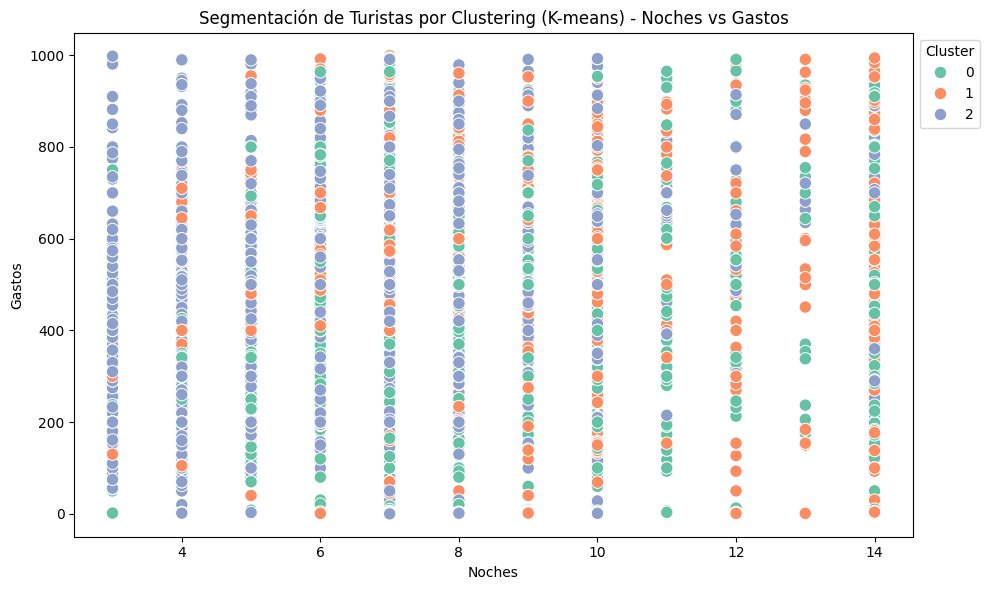

Cluster
2    2658
0    2141
1    1435
Name: count, dtype: int64


In [4]:
# Seleccionar las columnas numéricas para el análisis de clustering
columnas_cluster = ['Edad', 'Noches', 'Coste_vuelos', 'Coste_alojamiento', 'Gastos', 
                    'Horas_fuera_alojamiento', 'Visitas_totales_Islas', 'Visitas_total_GC', 'Personas_hogar']
df_cluster = df_2022[columnas_cluster].dropna()  # Eliminar valores nulos

# Estandarizar los datos
scaler = StandardScaler()
df_scaled_cluster = scaler.fit_transform(df_cluster)

# Aplicar K-means con un número específico de clusters (por ejemplo, 3)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(df_scaled_cluster)

# Añadir los clusters al DataFrame original
df_2022['Cluster'] = kmeans.labels_

#Gráfico
funciones.graficar_clusters(df_2022, 'Noches', 'Gastos', 'Cluster')

# Ver el número de turistas en cada cluster
print(df_2022['Cluster'].value_counts())


Los resultados del clustering indican que se han identificado 3 clusters de turistas. 
Estos clusters representan grupos de turistas con características similares basadas en las variables que utilizaste para el análisis de clustering (K-means). 

Con ello, veamos las características específicas de cada cluster para entender mejor cómo se comportan estos grupos de turistas.

In [5]:
# Seleccionar solo las columnas numéricas
numerical_columns = df_2022.select_dtypes(include=['float64', 'int64'])

# Agrupar por 'Cluster' y calcular la media para las columnas numéricas
cluster_profile = df_2022.groupby('Cluster')[numerical_columns.columns].mean()

# Mostrar el perfil de cada cluster
print(cluster_profile)


              Edad    Noches  Coste_vuelos  Coste_alojamiento      Gastos  \
Cluster                                                                     
0        46.340962  8.538066    182.809124          37.093319  258.685603   
1        56.280139  8.846690    407.511379         241.853109  356.013647   
2        45.039880  6.828442    457.821176         390.538503  400.818311   

         Horas_fuera_alojamiento  Visitas_totales_Islas  Visitas_total_GC  \
Cluster                                                                     
0                       5.102289               3.900514          1.951425   
1                       6.850871               9.784669          5.710105   
2                       8.041384               3.464635          1.693002   

         Personas_hogar     Año  
Cluster                          
0              2.898178  2022.0  
1              2.129617  2022.0  
2              1.970278  2022.0  


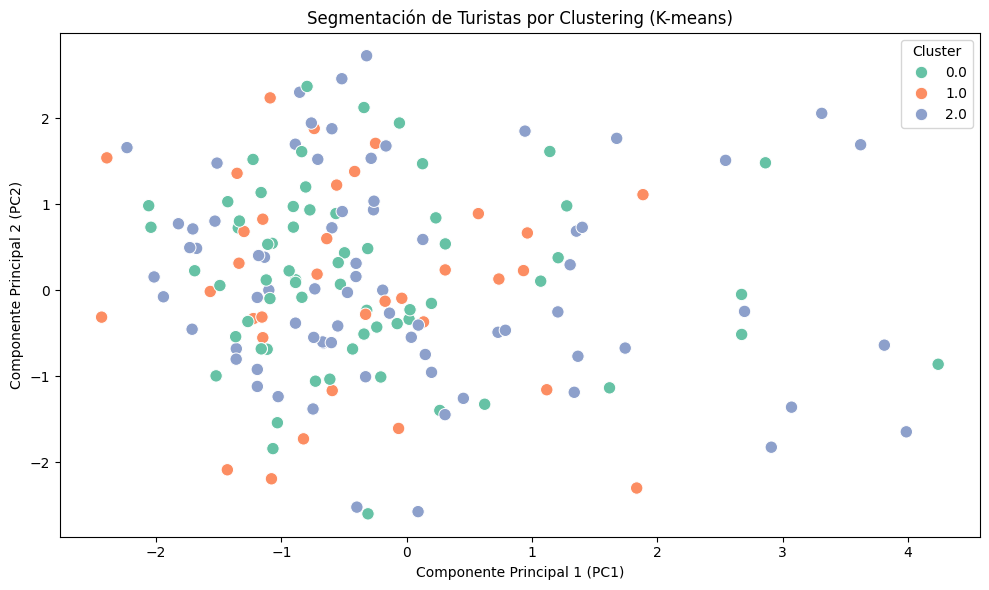

In [6]:
funciones.graficar_clusters_pca(pca_df, df_2022, 'Cluster')